In [1]:
# Veri işleme için kütüphaneler
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import kagglehub

# En güncel sürümü indir
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

100%|██████████| 163M/163M [00:08<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [8]:
import os

dataset_dir = "/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1"
print("Dataset yapısı:", os.listdir(dataset_dir))

Dataset yapısı: ['test', 'data', 'train_val']


In [10]:
def listele_dizin_yapisi(dizin):
    for root, dirs, files in os.walk(dizin):
        print("Geçerli dizin:", root)
        print("Alt klasörler:", dirs)
        print("Dosyalar:", files)
        print("-" * 40)

# İndirilen veri görüntüle
listele_dizin_yapisi(path)

Geçerli dizin: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1
Alt klasörler: ['test', 'data', 'train_val']
Dosyalar: []
----------------------------------------
Geçerli dizin: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/test
Alt klasörler: ['data']
Dosyalar: []
----------------------------------------
Geçerli dizin: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/test/data
Alt klasörler: []
Dosyalar: []
----------------------------------------
Geçerli dizin: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data
Alt klasörler: []
Dosyalar: []
----------------------------------------
Geçerli dizin: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/train_val
Alt klasörler: ['data']
Dosyalar: []
----------------------------------------
Geçerli dizin: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/train_val/data
Alt klasörler: ['without_mask', 'w

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, roc_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score)
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121  # veya MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Veri Yolu ve DataFrame Oluşturma
base_dir = "/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/train_val/data"
classes = ["without_mask", "with_mask"]

filepaths = []
labels = []
for label in classes:
    label_dir = os.path.join(base_dir, label)
    for fname in os.listdir(label_dir):
        if fname.lower().endswith(".jpg"):
            filepaths.append(os.path.join(label_dir, fname))
            labels.append(label)

df = pd.DataFrame({"filename": filepaths, "class": labels})
print("Toplam örnek sayısı:", len(df))

# 2. Veri Setini Eğitim/Validasyon ve Test Olarak Ayırma
train_val_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["class"], random_state=42
)

# Eğitim+Validasyon setini bölme
train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, stratify=train_val_df["class"], random_state=42
)

print("Eğitim örnek sayısı:", len(train_df))
print("Validasyon örnek sayısı:", len(val_df))
print("Test örnek sayısı:", len(test_df))

Toplam örnek sayısı: 7553
Eğitim örnek sayısı: 4833
Validasyon örnek sayısı: 1209
Test örnek sayısı: 1511


In [13]:
#3. Data Augmentation İçin ImageDataGenerator Tanımlama
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasyon ve Test için sadece yeniden ölçekleme uygulanacak
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=image_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=image_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=image_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 4833 validated image filenames belonging to 2 classes.
Found 1209 validated image filenames belonging to 2 classes.
Found 1511 validated image filenames belonging to 2 classes.


In [14]:
# 4. Önceden Eğitilmiş Modelin (DenseNet121) Hazırlanması
# Base model'ı indiriyoruz ve include_top=False ile son sınıflandırıcı katmanlarını hariç tutuyoruz.
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
base_model.trainable = False  # Başlangıçta base modeli donduruyoruz

# Yeni sınıflandırıcı katmanlarını ekleyelim
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
# Çıkış katmanı: 2 sınıf için softmax aktivasyon
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Modelin derlenmesi
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Alternatif olarak SGD(momentum=0.9) kullanılabilir.
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,366,210 (28.10 MB)

 Trainable params: 328,706 (1.25 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [15]:
# 5. Callback’lerin Tanımlanması
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

In [16]:
# 6. Modelin Eğitilmesi (En Fazla 100 Epok)
epochs = 100

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9327 - loss: 0.1632

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 114s 568ms/step - accuracy: 0.9331 - loss: 0.1623 - val_accuracy: 0.9967 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 353ms/step - accuracy: 0.9757 - loss: 0.0684 - val_accuracy: 0.9959 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.9800 - loss: 0.0558 - val_accuracy: 0.9967 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.9832 - loss: 0.0508 - val_accuracy: 0.9950 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 353ms/step - accuracy: 0.9831 - loss: 0.0465 - val_accuracy: 0.9983 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.9849 - loss: 0.0453 - val_accuracy: 0.9983 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 53s 349ms/step - accuracy: 0.9859 

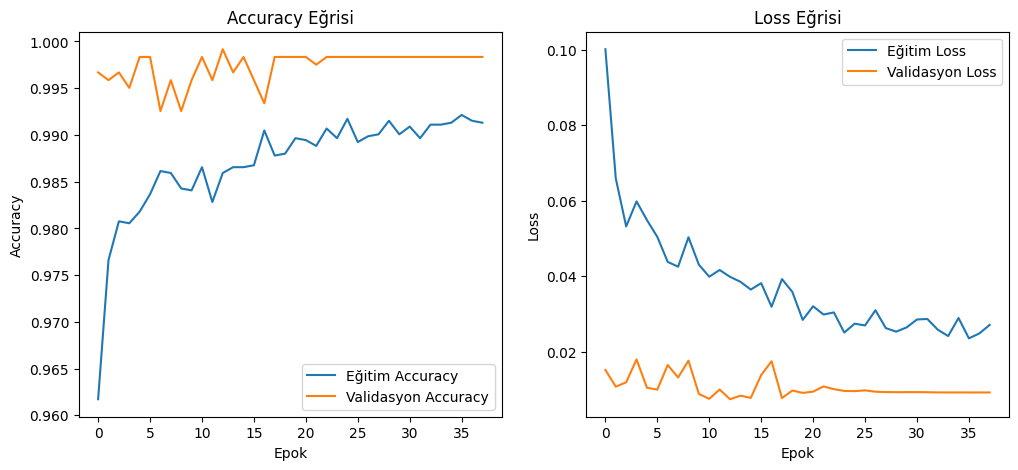

In [17]:
# 7. Eğitim ve Validasyon Eğrilerinin Çizdirilmesi
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Eğitim Accuracy')
plt.plot(history.history['val_accuracy'], label='Validasyon Accuracy')
plt.title("Accuracy Eğrisi")
plt.xlabel("Epok")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim Loss')
plt.plot(history.history['val_loss'], label='Validasyon Loss')
plt.title("Loss Eğrisi")
plt.xlabel("Epok")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [18]:
# 8. Test Verisi Üzerinde Modelin Değerlendirilmesi
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.9932 - loss: 0.0311
Test Loss: 0.024877063930034637
Test Accuracy: 0.9940437078475952


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
Confusion Matrix:
[[741   4]
 [  5 761]]
Accuracy: 0.9940436796823295
Precision: 0.9932975871313673
Recall: 0.9946308724832215
F1-score: 0.993963782696177
Specificity: 0.9946308724832215


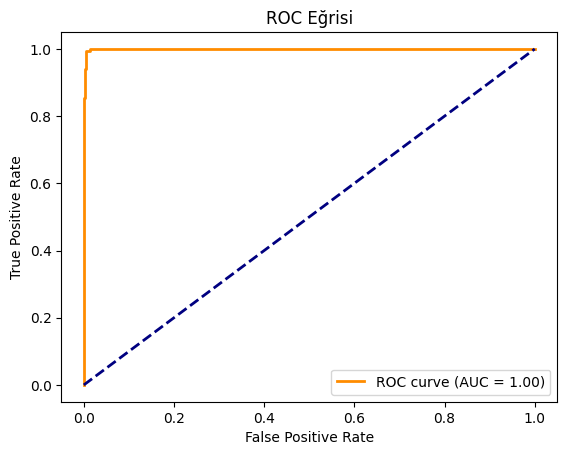

In [20]:
# 9. Test Verisinde Tahmin Yapma ve Metrik Hesaplamaları
test_generator.reset()
pred_probs = model.predict(test_generator)
preds = pred_probs.argmax(axis=1)
true_labels = test_generator.classes

# Karışıklık Matrisi
cm = confusion_matrix(true_labels, preds)
print("Confusion Matrix:")
print(cm)

# Accuracy, Precision, Recall, F1-score
acc = accuracy_score(true_labels, preds)
# Pozitif sınıf olarak 'with_mask' seçildi. Sınıf indekslerini kontrol ediniz.
pos_label = test_generator.class_indices['with_mask']
prec = precision_score(true_labels, preds, average='binary', pos_label=pos_label)
rec = recall_score(true_labels, preds, average='binary', pos_label=pos_label)
f1 = f1_score(true_labels, preds, average='binary', pos_label=pos_label)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

# Specificity hesaplama: Specificity = TN / (TN + FP)
if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)
else:
    print("Karışıklık matrisi 2x2 boyutunda değil.")

# ROC Eğrisi ve AUC Hesaplaması
# ROC için pozitif sınıf 'with_mask' için olasılıkları alıyoruz.
y_true = (np.array(true_labels) == pos_label).astype(int)
y_scores = pred_probs[:, pos_label]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

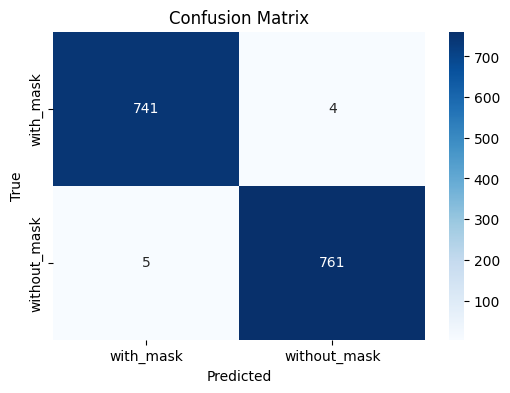

In [21]:
# Karışıklık Matrisi'ni görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()